In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from prophet import Prophet

/var/folders/bt/nlh_3ptx6znf2gx6qszlwdxm0000gn/T/ipykernel_1003/3862201560.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv("../Data/RawTrafficData.csv", index_col=0)
df.index = pd.to_datetime(df.index)
matplotlib.rcParams.update({'font.size': 14})

In [3]:
df_prophet = df.reset_index().rename(columns={'index': 'ds', 'value': 'y'})

In [4]:
df_prophet.head()

,ds,y
0,2023-09-01 00:00:00,1.825067
1,2023-09-01 01:00:00,2.121939
2,2023-09-01 02:00:00,2.357743
3,2023-09-01 03:00:00,2.932698
4,2023-09-01 04:00:00,2.886991


In [5]:
train = df_prophet[:800]
test = df_prophet[801:]

In [6]:
model = Prophet(interval_width=0.99)
model.fit(train)

forecastlen = len(test)

future = model.make_future_dataframe(periods=forecastlen,freq ='h')

09:07:05 - cmdstanpy - INFO - Chain [1] start processing
09:07:05 - cmdstanpy - INFO - Chain [1] done processing


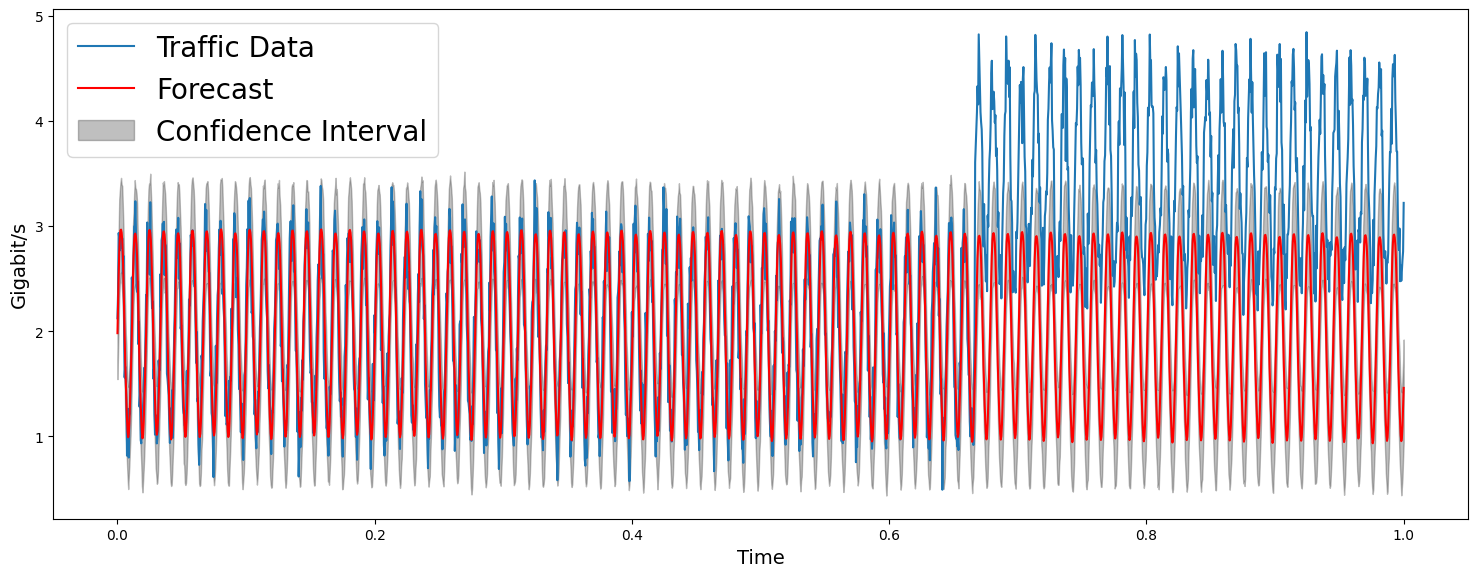

In [7]:
forecast = model.predict(future)
x = np.linspace(0,1,len(forecast))

fig, axs = plt.subplots(1, 1, figsize=(15, 6))
axs.plot(x, df_prophet.y[1:], label='Traffic Data')
axs.plot(x,forecast["yhat"], label="Forecast", color="red")

axs.fill_between(x,
                 forecast["yhat_lower"],  # Lower bound of CI
                 forecast["yhat_upper"],  # Upper bound of CI
                 color='k', alpha=.25, label="Confidence Interval")

axs.legend(fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel('Gigabit/s')
plt.xlabel('Time')
plt.tight_layout()
plt.savefig('./GeneratedPlots/ProphetForecast.png') 
plt.show()

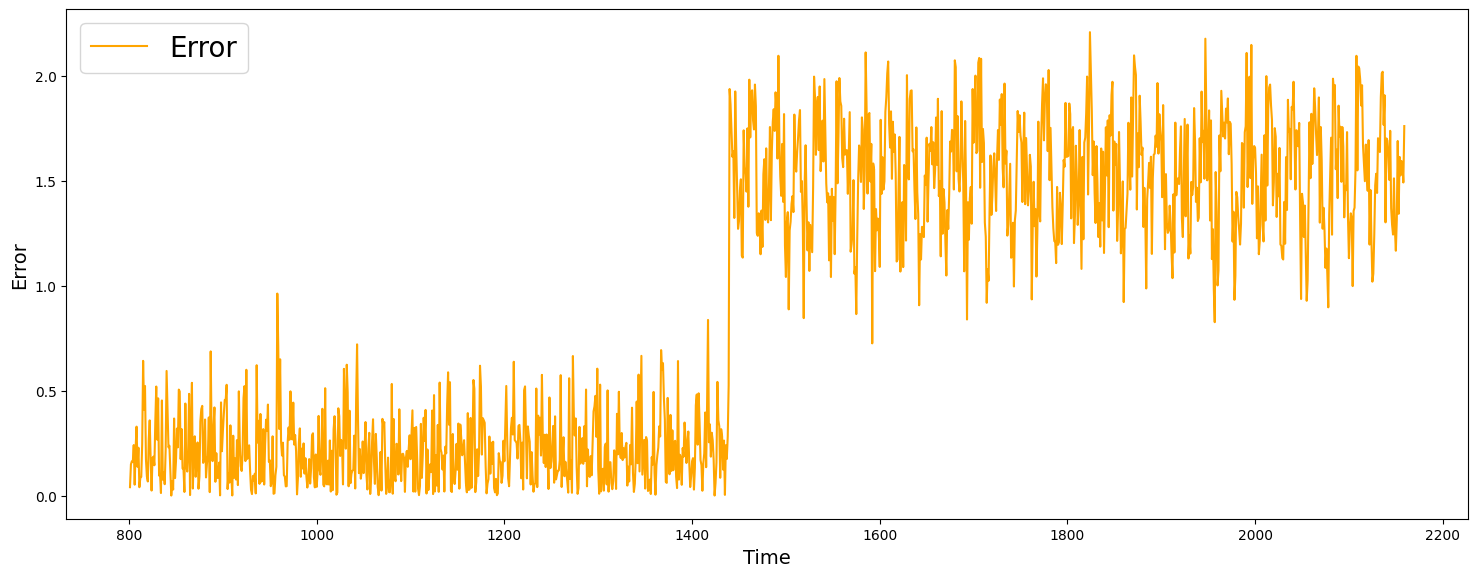

In [8]:
test_data_forecasts = np.array(forecast["yhat"][800:])
ground_truth = test.y

errors = np.abs(ground_truth-test_data_forecasts)

fig, axs = plt.subplots(1, 1, figsize=(15, 6))
axs.plot(errors, label = "Error", color="orange")
axs.legend(fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel('Error')
plt.xlabel('Time')
plt.tight_layout()
plt.savefig('./GeneratedPlots/ForecastError.png') 
plt.show()

# Anomaly Detection using ARIMA and Confidence Interval

09:25:46 - cmdstanpy - INFO - Chain [1] start processing
09:25:46 - cmdstanpy - INFO - Chain [1] done processing


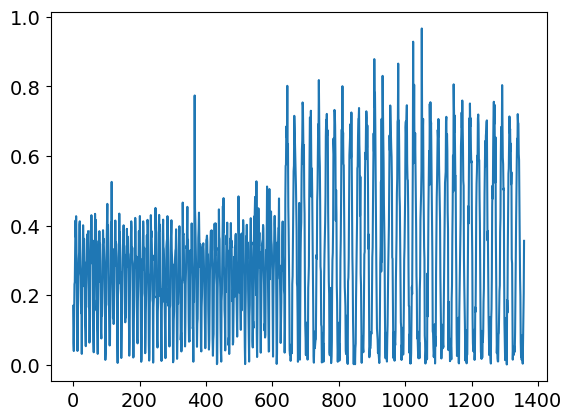

In [32]:
df = pd.read_csv("../Data/RawTrafficData.csv", index_col=0)
df.index = pd.to_datetime(df.index)

base_series = df.value
time = np.arange(0, len(base_series), 1) 
start_index = math.floor((1/2)*len(df.value))

proportion_anomalies = 0.007
num_anomalies = int((len(time) - start_index) * proportion_anomalies) # this will be mutltiplied with 2 since there will be upwards and downwards point anomalies

anomalous_series = base_series.copy()

#Positive Point Anomalies
p_anomaly_indices = np.random.choice(range(start_index, len(time)), num_anomalies, replace=False)
anomaly_amplitudes = np.random.uniform(0.7, 2.0, num_anomalies)

anomalous_series.iloc[p_anomaly_indices] += anomaly_amplitudes

#Negative Point Anomlaies
n_anomaly_indices = np.random.choice(range(start_index, len(time)), num_anomalies, replace=False)
anomaly_amplitudes = np.random.uniform(-2.0, -0.7, num_anomalies)

anomalous_series.iloc[n_anomaly_indices] += anomaly_amplitudes

anomaly_indices = np.append(p_anomaly_indices, n_anomaly_indices)
    
df['Anomalie_Data'] = anomalous_series
df['Anomalous'] = 0
df.iloc[anomaly_indices, df.columns.get_loc('Anomalous')] = 1

drift_index = math.floor((2/3)*len(anomalous_series))
df.iloc[drift_index, df.columns.get_loc('Anomalous')] = 1
df = df.drop(["value"], axis=1)
df_prophet = df.reset_index().rename(columns={'index': 'ds', 'Anomalie_Data': 'y'})

train = df_prophet[:800]
test = df_prophet[801:]

model = Prophet(interval_width=0.99)
model.fit(train)

forecastlen = len(test)

future = model.make_future_dataframe(periods=forecastlen,freq ='h')
forecast = model.predict(future)

ground_truth_values = test.y
anomaly_scores = np.zeros(len(ground_truth_values))

for i, true_value in enumerate(ground_truth_values):
    lower_bound = forecast["yhat_lower"][i]
    upper_bound = forecast["yhat_upper"][i] 
    prediction = forecast["yhat"][i]
    
    threshold = np.abs(prediction-upper_bound) * 10
    error = np.abs(true_value - prediction)

    if error >= threshold:
        anomaly_scores[i] = 1.0
    else:
        anomaly_scores[i] = error / threshold

plt.plot(anomaly_scores)


In [33]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

anomaly_scores = np.array(anomaly_scores)  
true_labels = test.Anomalous

thresholds = np.arange(0.0, 1.01, 0.01) 
max_f1 = 0
optimal_threshold = 0

for threshold in thresholds:
    predicted_labels = np.where(anomaly_scores >= threshold, 1, 0)
    f1 = f1_score(true_labels, predicted_labels)

    if f1 > max_f1:
        max_f1 = f1
        optimal_threshold = threshold

print(optimal_threshold)
predicted_labels = np.where(anomaly_scores >= optimal_threshold, 1, 0)

accuracy = accuracy_score(true_labels, predicted_labels)
tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()

recall = recall_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"Accuracy: {accuracy}")
print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
print(f"Recall: {recall}, Precision: {precision}, F1 Score: {f1}")

0.88
Accuracy: 0.9904341427520236
TP: 2, FP: 0, TN: 1344, FN: 13
Recall: 0.13333333333333333, Precision: 1.0, F1 Score: 0.23529411764705882


# Just score everything before the ConceptDrift and after

In [34]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

anomaly_scores = np.array(anomaly_scores)  
true_labels = np.array(df.Anomalous[801:]) 

CD_index = 640

anomaly_scores_BCD  = anomaly_scores[:CD_index]
true_labels_BCD  = true_labels[:CD_index]

true_labels_ACD  = true_labels[CD_index+1:]
anomaly_scores_ACD  = anomaly_scores[CD_index+1:]

# Before CD

thresholds = np.arange(0.0, 1.01, 0.01) 
max_f1 = 0
optimal_threshold = 0

for threshold in thresholds:
    predicted_labels = np.where(anomaly_scores_BCD >= threshold, 1, 0)
    f1 = f1_score(true_labels_BCD, predicted_labels)

    if f1 > max_f1:
        max_f1 = f1
        optimal_threshold = threshold

optimal_pre_concept_drift = optimal_threshold
predicted_labels = np.where(anomaly_scores_BCD >= optimal_threshold, 1, 0)

accuracy = accuracy_score(true_labels_BCD, predicted_labels)
tn, fp, fn, tp = confusion_matrix(true_labels_BCD, predicted_labels).ravel()

recall = recall_score(true_labels_BCD, predicted_labels)
precision = precision_score(true_labels_BCD, predicted_labels)
f1 = f1_score(true_labels_BCD, predicted_labels)

print("Before CD")
print(f"Accuracy: {accuracy}")
print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
print(f"Recall: {recall}, Precision: {precision}, F1 Score: {f1}")



# After CD


thresholds = np.arange(0.0, 1.01, 0.01) 
max_f1 = 0
optimal_threshold = 0

for threshold in thresholds:
    predicted_labels = np.where(anomaly_scores_ACD >= threshold, 1, 0)
    f1 = f1_score(true_labels_ACD, predicted_labels)

    if f1 > max_f1:
        max_f1 = f1
        optimal_threshold = threshold
        
predicted_labels = np.where(anomaly_scores_ACD >= optimal_threshold, 1, 0)

accuracy = accuracy_score(true_labels_ACD, predicted_labels)
tn, fp, fn, tp = confusion_matrix(true_labels_ACD, predicted_labels).ravel()

recall = recall_score(true_labels_ACD, predicted_labels)
precision = precision_score(true_labels_ACD, predicted_labels)
f1 = f1_score(true_labels_ACD, predicted_labels)

print("After CD")
print(f"Accuracy: {accuracy}")
print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
print(f"Recall: {recall}, Precision: {precision}, F1 Score: {f1}")


# After CD using same threshold as before CD

predicted_labels = np.where(anomaly_scores_ACD >= optimal_pre_concept_drift, 1, 0)

accuracy = accuracy_score(true_labels_ACD, predicted_labels)
tn, fp, fn, tp = confusion_matrix(true_labels_ACD, predicted_labels).ravel()

recall = recall_score(true_labels_ACD, predicted_labels)
precision = precision_score(true_labels_ACD, predicted_labels)
f1 = f1_score(true_labels_ACD, predicted_labels)

print("After CD using threshold from before CD")
print(f"Accuracy: {accuracy}")
print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
print(f"Recall: {recall}, Precision: {precision}, F1 Score: {f1}")

Before CD
Accuracy: 0.99375
TP: 3, FP: 2, TN: 633, FN: 2
Recall: 0.6, Precision: 0.6, F1 Score: 0.6
After CD
Accuracy: 0.9888579387186629
TP: 2, FP: 0, TN: 708, FN: 8
Recall: 0.2, Precision: 1.0, F1 Score: 0.3333333333333333
After CD using threshold from before CD
Accuracy: 0.6434540389972145
TP: 3, FP: 249, TN: 459, FN: 7
Recall: 0.3, Precision: 0.011904761904761904, F1 Score: 0.022900763358778626
